In [1]:
! pip install -r requirements.txt --quiet

In [ ]:
from dotenv import load_dotenv
from os import environ
from langchain_openai import AzureChatOpenAI
from typing_extensions import TypedDict,Literal
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display
from  user_tools import get_weather_tool,convert_fahrenheit_to_celsius
from user_functions import vector_search  
from utils import pretty_print_messages
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

from langchain_community.utilities.graphql import GraphQLAPIWrapper
from langchain_community.tools.graphql.tool import BaseGraphQLTool

import requests
import json

load_dotenv(override=True)


True

In [222]:
members = ["document_search", "tools_agent", "datacenterenergyusage"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers: "
    f"{members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and "
    "respond with their results and status. When finished, respond with 'FINISH'.\n\n"
    "Note: The 'datacenterenergyusage' worker handles queries related to data center tabular queries on energy, "
    "power, or consumption topics. When returning datetime values, format them in the ISO 8601 standard (e.g., '2025-04-17T12:30:00Z').\n\n"
    "Additionally, whenever a temperature in Fahrenheit (°F) is mentioned, "
    "you must immediately and automatically convert it to Celsius (°C) using the available tool. "
    "Do not ask the user for confirmation, clarification, or any additional input. "
    "Always perform the conversion as part of the response.\n\n"
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

llm = AzureChatOpenAI(
        temperature=0,
        azure_deployment=environ["AZURE_OPENAI_MODEL"],
        api_version=environ["AZURE_OPENAI_API_VERSION"]
    )

In [223]:
graphql_wrapper = GraphQLAPIWrapper(graphql_endpoint=environ["GRAPHQL_URL"])

graphql_tool = BaseGraphQLTool(graphql_wrapper=graphql_wrapper)

In [224]:
tools = [get_weather_tool, convert_fahrenheit_to_celsius]


llm_with_tools = create_react_agent(llm, tools=tools)


datacenter_agent = create_react_agent(
    llm,
    tools=[graphql_tool]
)

In [225]:

def get_graphql_schema_and_update_state(state: MessagesState):
  
    messages = state.get("messages", [])
    
    # Define the introspection query
    introspection_query = """
    {
      __schema {
        types {
          name
          fields {
            name
          }
        }
      }
    }
    """
    

    introspection_response = json.loads(graphql_wrapper.run(introspection_query))
    schema_data = introspection_response.get("__schema", {}).get("types", [])
    schema_content = json.dumps(schema_data, indent=2)
    
    messages.append(
        SystemMessage(content=f"GraphQL Schema:\n{schema_content}")
    )
    
    state["messages"] = messages
    state["graphql_schema"] = schema_data  
    
    return state


In [226]:
def document_search(state: MessagesState) -> Command[Literal["supervisor"]]:
    messages = state["messages"]
    last_user_message = next((msg for msg in reversed(messages)), None)
    if not last_user_message:
        return Command(goto="supervisor")

    query = last_user_message.content
    context = vector_search(query)  

    
    messages.append(
    SystemMessage(
        content=(
            f"You are a helpful assistant. Use only the information in the context below to answer the user's question. "
            f"If the context does not contain the answer, respond with \"I don't know.\"\n\nContext:\n{context}"
        )
    )
    )

    response = llm.invoke(messages)

    return Command(
        update={
            "messages": [
                HumanMessage(content=response.content, name="document_search")
            ]
        },
        goto="supervisor",
    )


def tools_agent(state: MessagesState) -> Command[Literal["supervisor"]]:
    
    result = llm_with_tools.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="tools_agent")
            ]
        },
        goto="supervisor",
    )


def datacenterenergyusage(state: MessagesState) -> Command[Literal["supervisor"]]:
    state = get_graphql_schema_and_update_state(state)
    result = datacenter_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="datacenterenergyusage")
            ]
        },
        goto="supervisor",
    )


def supervisor(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt}, 
    ] + state["messages"]

    
    
    response = llm.with_structured_output(Router).invoke(messages)


    
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



In [227]:

builder = StateGraph(MessagesState)
builder.add_node("document_search", document_search)
builder.add_node("tools_agent", tools_agent)
builder.add_node("datacenterenergyusage", datacenterenergyusage)
builder.add_node("supervisor", supervisor)

builder.set_entry_point("supervisor")

graph = builder.compile()


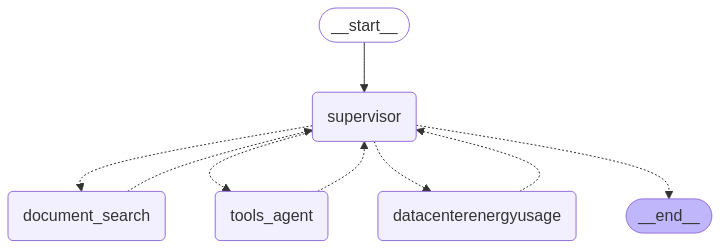

In [228]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [229]:
for step in graph.stream({"messages": [{"role": "user", "content": "Return Data Center Temperatures?"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node datacenterenergyusage:


================================ Human Message =================================
Name: datacenterenergyusage

Here are the recorded temperatures for various data centers and zones:

1. **Data Center ID:** DC-CHI2, **Zone:** C3, **Temperature:** 22.49°C, **Timestamp:** 2025-04-14T15:15:13.724337
2. **Data Center ID:** DC-NYC1, **Zone:** B2, **Temperature:** 29.66°C, **Timestamp:** 2025-04-14T15:00:13.724337
3. **Data Center ID:** DC-NYC1, **Zone:** B2, **Temperature:** 23.13°C, **Timestamp:** 2025-04-14T14:45:13.724337
4. **Data Center ID:** DC-CHI2, **Zone:** C3, **Temperature:** 21.43°C, **Timestamp:** 2025-04-14T14:30:13.724337
5. **Data Center ID:** DC-CHI2, **Zone:** B2, **Temperature:** 24.26°C, **Timestamp:** 2025-04-14T14:15:13.724337
6. **Data Center ID:** DC-CHI2, **Zone:** A1, **Temperature:** 24.69°C, **Timestamp:** 2025-04-14T14:00:13.724337
7. **Data Center ID:** DC-NYC1, **Zone:** B2, **Temperature

In [230]:
for step in graph.stream({"messages": [{"role": "user", "content": "What are the Data Center Space Types?"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node document_search:


================================ Human Message =================================
Name: document_search

The data center space types considered in the study are:

1. **Telco Edge**: Small closets/rooms to micro data centers and network infrastructure deployed by communications companies as points of presence throughout their network.

2. **Commercial Edge**: Network closets, server rooms, and micro-data centers supporting digital infrastructure and software delivery services for commercial and industrial edge locations.

3. **Small and Medium Businesses (SMB)**: Data center deployments within internal facilities of small and medium businesses.

4. **Enterprise Branch**: Remote and branch office (ROBO) deployments for large enterprises in their own internal facilities, such as network closets and server rooms.

5. **Internal**: Data centers operated internally by enterprises for their own use.

6. **Communications Servi

In [231]:
for step in graph.stream({"messages": [{"role": "user", "content": "what is the weather in sf"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node tools_agent:


================================ Human Message =================================
Name: tools_agent

The weather in San Francisco is currently 60°F and foggy.


Update from node supervisor:




Update from node tools_agent:


================================ Human Message =================================
Name: tools_agent

The current weather in San Francisco is 60°F and foggy. Would you like me to convert the temperature to Celsius?


Update from node supervisor:




Update from node tools_agent:


================================ Human Message =================================
Name: tools_agent

The current weather in San Francisco is 15.6°C and foggy.


Update from node supervisor:




